# Delarue Simon
# Télécom Paris | MS BGD | MDI343
February 2021
## Data Challenge - Supervised anomaly detection

**Objective**  

> _The main goal of this project is to detect anomalies on one of Valeo's production line (Valeo is a French Original Equipment Manufacturer). To perform this, it is required to build a machine learning model that can provides anomaly score for each produced item on the line - based on measured parameters of the item. The greater the score, the greater item's probability of being defectious (i.e anomaly)._

**Abstract**  

Learning from an imbalanced dataset is a classic problem in machine learning tasks. A few approaches to deal with it can be considered on different levels. Balancing the training dataset by oversampling the minority class, undersampling the majority class or enlarging the feature space with new information based on data. On the algorithm level, one can act on cost function by adjusting class weights or by tuning models to take into account data's specificities.  
The approach presented here can be summarized by the following steps. For each one of them, we are trying to get the best **AUC** :  
* I quickly checked the datasets and noticed the strongly unbalanced classes (Anomalies representing 2.51% of the training dataset).  
First, I decided to focus on testing several models on the original data (yet scaled), by trying techniques that usually show good results in Kaggle challenges (random forest, SVM and especially boosting techniques like XGBoost, LightGBM or CatBoost). I've also tried stacking methods (detailed further) on models that showed great performances. During these steps, I mainly focused on the **cost sensitive** aspect, by tuning hyperparameters to fit Veolia's data specificities (especially, acting on cost function by weighting data with the `scale_pos_weight` parameter. These methods led to a maximum **public test score of 80.2869 (XGBoost)**. Interestingly, even thought stacking methods were showing better results on validation set, it didn't improve public test score.  
* The predictions evaluated by the classifiers are generated with respect to the starting kit conditions ; they can be ordered by their probability of being an anomaly. However, the range of these predictions was often really small and difficult to be considered by human. I've decided to implement a **calibration technique**, in order to reshape the prediction's range and get more intuition about the probability of an item being an anomaly (using **Brier Score**). I've also tried to use these calibrations to improve predicted AUC, which was successfull for LightGBM classifier.  
* Then, taking into account that noise was generated because of strongly unbalanced classes, and also because of the overlapping classes pattern, I've followed the litterature's results on these problems, and tried **sampling methods** (oversampling and undersampling), that act directly on data, like SMOTE and SMOTE's variants (Borderline SMOTE and SVM Smote). However, these techniques led to bigger overfitting than previous tries, thus **lowered public test score**.
* Finally, I've tried some **feature engineering** techniques. Because the dataset is not massive, I've tried to enlarge the original feature space by computing either **pairwise operations** on the existing features, or **quadratic forms**. Also, considering that some data were **duplicated** in the training and test sets, I've created an additional feature, `dup` that equals $1$ fi sample is duplicated and $0$ otherwise. This field extracts information about Veolia measuring again some samples, and we can hypothetize that this is done because these samples were suspicious. If it is the case, it gives great information about the probability of an item being defectious. This field allowed me to improve significantly my public test score, which jumped to **89.4506 (XGBoost)**. 

**Results**  

Best Public Test Score : __89.4506 (AUC)__  

| Model|Feature engineering|Stacking|Valid AUC|Public Test AUC|
|------|-------------------|--------|---------|---------------|
|SGDClassifier (baseline)|Initial features|No|77.167%|74.859%|
|XGBoost|Initial features|No|84.003%|80.287%|
|Random Forest|Enlarged features|No|88.717%|87.675%|
|XGB + LGBM + RandF|Enlarged features|Yes|91.171%|87.984%|
|CatBoost|Enlarged features|No|89.968%|89.261%|
|LightGBM|Enlarged features|No|90.560%|89.381%|
|**XGBoost**|Enlarged features|No|90.714%|**89.450%**|

**Table of contents**  

1. [Utilities](#Utilities)    
    1.1. [Libraries](#Libraries)  
    1.2. [Data](#Data)  
    1.3. [Functions](#Functions)  
2. [Exploratory Data Analysis](#ExploratoryDataAnalysis)  
    2.2. [General aspect of Data](#GeneralAspect)  
    2.2. [Feature correlations](#FeatCorr)  
    2.3. [Principal Components Analysis (PCA)](#PCA)    
3. [Feature Engineering](#FeatureEngineering)  
    3.1. [Sampling Methods](#SamplingMethods)  
    3.2. [Enlarging Feature space](#EnlargeFeat)  
    3.3. [Train Test Split](#TrainTestSplit)   
    3.4. [Probability Calibration](#ProbCalib)
4. [Models](#Models)  
    4.1. [Support Vector Machines](#SVM)  
    4.2. [Xtreme Gradient Boosting (XGBoost)](#XGBoost)  
    4.3. [Light Gradient Boosting](#LGBM)  
    4.4. [CatBoost](#CatBoost)  
    4.5. [Random Forest](#RandF)  
5. [Stacking](#Stacking)  

## 1. Utilities <a class="anchor" id="Utilities"></a>
### 1.1 Libraries <a class="anchor" id="Libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pickle
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, recall_score, \
                            precision_score, f1_score, plot_roc_curve, auc, brier_score_loss

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cbt
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Data  <a class="anchor" id="Data"></a>
Let's load both training and test datasets and have a look at their shapes.

In [2]:
X_train = pd.read_csv('data/valeo_xtrain.csv')
y_train = pd.read_csv('data/valeo_ytrain.csv')
X_test = pd.read_csv('data/valeo_xtest.csv')

print(f'X_train\'s shape : {X_train.shape}')
print(f'y_train\'s shape : {y_train.shape}')
print(f'X_test\'s shape  : {X_test.shape}')

X_train's shape : (27586, 27)
y_train's shape : (27586, 1)
X_test's shape  : (27587, 27)


### 1.3 Functions  <a class="anchor" id="Functions"></a>

Here we define a few functions that we will use later in the project.

In [3]:
def apply_PCA(X, plot=True):
    ''' Fit PCA on data, then plot explained variance if needed 
        Parameter
        ----------
            X : Dataframe that will be scaled and transformed according to PCA 
            plot : Boolean. If True, displays the explained variance by principal components of PCA 
        
        Output
        -------
            Array of principal components resulting from PCA
            Vector of explained variance 
            '''
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    pca_comp = pca.fit_transform(X_scaled)
    explained_var = pca.explained_variance_ratio_
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(range(0, len(explained_var)), explained_var.cumsum(), marker='o')
        ax.set(xlabel = 'Principal components',
               ylabel = 'Inertia')
        plt.axvline(x = 11, color='r', linestyle='--')
        plt.title('Amount of inertia explained by principal components', fontweight='bold')
        plt.show()
    
    return pca_comp, explained_var


def plot_pca_3D(pca_components, labels):
    ''' Plot values of principal components of PCA 
        Parameters
        -----------
            pca_components : Array resulting from fitting PCA to data
            labels : ground truth labels from data '''
    
    not_anomalies = pca_components[labels['Anomaly']==0]
    anomalies = pca_components[labels['Anomaly']==1]
    
    plot3D = plt.figure().gca(projection='3d')    
    plot3D.scatter(anomalies[:, 2], anomalies[:, 0], anomalies[:, 1], label='Anomaly', color='r', alpha=1)
    plot3D.scatter(not_anomalies[:, 2], not_anomalies[:, 0], not_anomalies[:, 1],  label='Not Anomaly', color='g', alpha=0.2)    
    plot3D.set_xlabel('First Component')
    plot3D.set_ylabel('Second Component')
    plot3D.set_zlabel('Third Component')
    
    
def plot_learning_auc(cv, model_name, ax):
    ''' Plot mean AUC learning curve based on cross validation result table (Gradient Boosting methods)
        Parameters
        -----------
            cv : Gradient boosting cross validation output DataFrame
            model_name : String for plot title 
            ax : Location of plot in the figure (ex : ax[0])
            
        Ouput
        -----------
            ax : Return axe to fill figure '''
    
    ax.plot(range(cv.shape[0]), cv['train-auc-mean'], label='Train AUC', color='b')
    ax.plot(range(cv.shape[0]), cv['test-auc-mean'], label='Valid AUC', color='g')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Mean AUC')
    ax.set_title(f'Learning curve - {model_name}', fontweight='bold')
    ax.legend();
    return ax


def plot_roc_curve_manual(y, y_pred, model_name, ax):
    ''' Plot ROC Curve based on model predictions, with focus on AUC metric 
        Parameters
        -----------
            y : Array of ground truth values to predict
            y_pred : Array of predictions (i.e output of model)
            model_name : String for plot title
            ax : Location of plot in the figure (ex. ax[0])
        
        Ouput
        -----------
            ax : Return axe to fill figure '''
    
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, label=f'AUC {model_name} : {roc_auc_score(y, y_pred):.5f}')
    ax.plot([0, 1],[0, 1], ls='--', color='black')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve Validation set', fontweight='bold')
    ax.legend(prop={'size': 11});
    return ax

def calibrate_predictions(classifier, X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_test, cv, method):
    ''' Calibrate predictions in order to get more intuition about the probability of an item being an anomaly
        Parameters
        -----------
            classifier : Classifier model to calibrate
            X_train, y_train, X_test, y_test : Datasets for training and test (or validation)
            sample_weight_train, sample_weight_test : Weights of target value in the original dataset
            cv : Cross-validation set
            method : Method used to calibrate predictions : ['Isotonic', 'Sigmoid']
        
        Output
        -----------
            clf_calib : Fitted classifier
            preds_calib : Calibrated predictions with respect to the method (output is base on predict_proba() function)
            clf_brier_score : Brier Score of calibration '''
    
    # Fit calibratedClassifier
    clf_calib = CalibratedClassifierCV(classifier, cv=cv, method=method)
    clf_calib.fit(X_train, y_train, sample_weight=sample_weight_train)
    
    # Predictions
    preds_calib = clf_calib.predict_proba(X_test)[:, 1]
    
    # Brier Score
    clf_brier_score = brier_score_loss(y_test, preds_calib, sample_weight=sample_weight_test.ravel())
    
    return clf_calib, preds_calib, clf_brier_score

def plot_predictions(y_pred, calibration_type, brier_score, ax):
    ''' Plot calibrated predictions
        Parameter
        ----------
            y_pred : Array of predictions (i.e output of model)
            calibration_type : Method used for calibration
            brier_score : Brier score (output of calibration)
            ax : Location of plot in the figure (ex. ax[0])

        Output
        ---------
            ax : Return ax to fill figure '''
    
    ax.plot(range(len(y_pred)), np.sort(y_pred), label=f'{calibration_type} ({brier_score:.4f})')
    ax.legend()
    ax.set_title('Model predictions by calibration type (Brier score)', fontweight='bold')
    ax.set_ylabel('$P(Y=1)$')
    ax.set_xlabel('Instances (ordered)');
    
    return ax

## 2. Exploratory Data Analysis <a class="anchor" id="ExploratoryDataAnalysis"></a>

### 2.1 General aspect of data  <a class="anchor" id="GeneralAspect"></a>  

Before going deeper in the data analysis, let's check out some general aspects of the dataset ; 
- are there any missing values (NaN)  
- are there any duplicated values
- is there a difference between the features in the training and test sets  
- differences between features distribution in anomaly/not anomaly classes

**Missing values**  
None of the datasets contain missing values.

In [4]:
print(f'Missing values in X_train : {X_train.isnull().sum().sum()}')
print(f'Missing values in y_train : {y_train.isnull().sum().sum()}')
print(f'Missing values in X_test  : {X_test.isnull().sum().sum()}')

Missing values in X_train : 0
Missing values in y_train : 0
Missing values in X_test  : 0


**Duplicated values**  
Some values are duplicated in the dataset, we will focus on them in the _Feature Engineering_ part.

In [4]:
print(f'Number of duplicated samples in X_train : {X_train.duplicated().sum()}')
print(f'Number of duplicated samples in X_test  : {X_test.duplicated().sum()}')

Number of duplicated samples in X_train : 327
Number of duplicated samples in X_test  : 353


**Features coherence between train and test sets**  
The training and test sets both contain 27 features, and these features are similar. In addition, the training and test sets do not share any items in common.

In [5]:
print(f'Number of features in Train set : {len(X_train.columns)} - in Test set : {len(X_test.columns)}')
print(f'Features are similar between train and test sets : {all(X_train.columns == X_test.columns)}')

Number of features in Train set : 27 - in Test set : 27
Features are similar between train and test sets : True


**Features distributions by classes**  
We take a quick look a the features distribution by target class. By comparing boxplots, we would be able to spot features which have specific distribution if the item is an anomaly or not. However, it doesn't seem that any feature shows this kind of information.

In [6]:
anomalies = X_train[y_train['Anomaly']==1]
not_anomalies = X_train[y_train['Anomaly']==0]

#for idx in range(len(X_train.columns)):
#    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
#    plt.boxplot([anomalies[anomalies.columns[idx]], not_anomalies[anomalies.columns[idx]]])
#    plt.title(anomalies.columns[idx])
#    plt.xticks([1, 2], ['Anomaly', 'Non anomaly']);

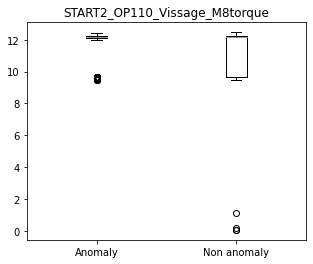

In [7]:
# Example on 1 feature 
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.boxplot([anomalies[anomalies.columns[24]], not_anomalies[anomalies.columns[24]]])
plt.title(anomalies.columns[24])
plt.xticks([1, 2], ['Anomaly', 'Non anomaly']);

### 2.2 Features correlations  <a class="anchor" id="FeatCorr"></a>  
It can be interesting to get an intuition about the correlations between features, and the correlations between each feature and the target. However, in the next parts of this document, we will focus on **regularization** parameters of our algorithms, instead of trying to reduce the feature space. Indeed, the public test score after computing **PCA** on data didn't show any improvement.

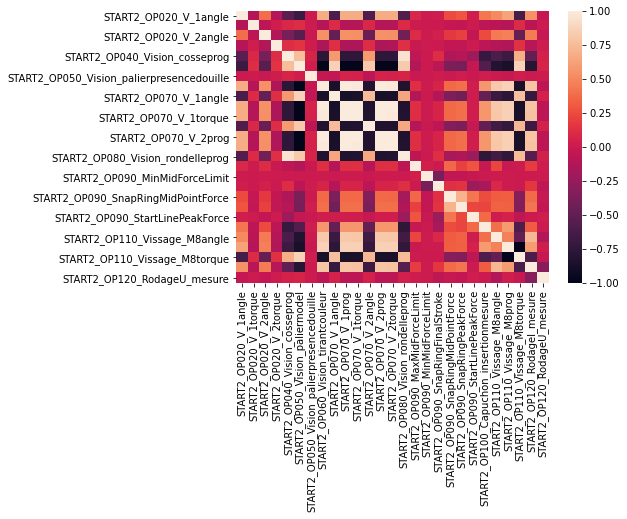

In [8]:
corr = X_train.corr()
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(corr);

**Feature correlation with target**

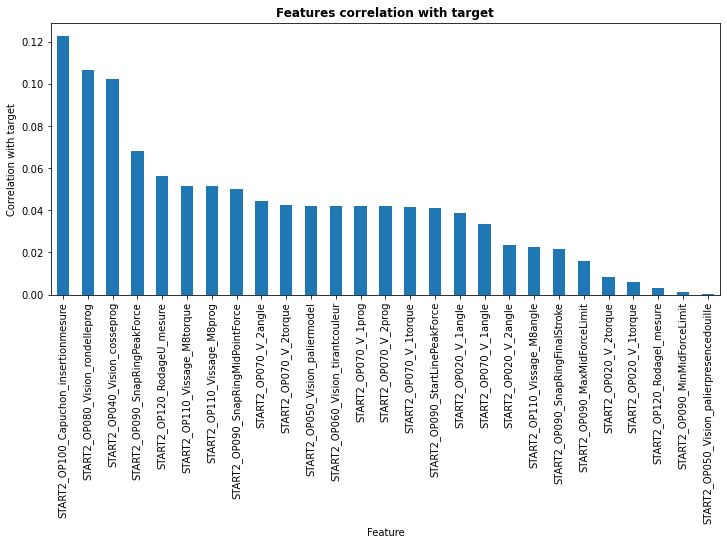

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
corr_target = np.abs(pd.concat([X_train, y_train], axis=1).corr()['Anomaly']).sort_values(ascending=False)[1:].plot(kind='bar')
plt.title('Features correlation with target', fontweight='bold')
plt.ylabel('Correlation with target')
plt.xlabel('Feature');

We notice that several features show great correlations, but none of them is highly correlated with the target.

### 2.3 Principal components analysis (PCA)  <a class="anchor" id="PCA"></a>  
As we mentionned, applying PCA before fitting models didn't seem to improve public test score, nonetheless, PCA is a great tool to reduce data dimension and be able to get a good intuition of the data with a visualization. Let's try this here.

**Variance explained by principal components**  
We first take a look at the Inertia explained by the principal components of the data. We notice that there is no clear **elbow** in the plot, which leads us to think that none of the features explain a significant part of the total variance.  
By selecting 11 features above 27, we can explain approwximately **90% of the total variance** though.

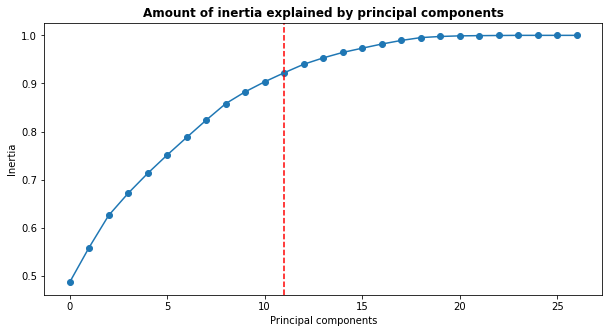

In [8]:
# Fit PCA to X_train data
pca_components, _ = apply_PCA(X_train, plot=True)

**Visualization**  

Interestingly, we can note there are some outliers that remains in the 'Not Anomaly' class (see below). We can hypothetize that these points are failures of sensors. To get a cleaner view of data, en also to ensure that we do not add noise in the already strongly unbalanced classes, I remove the two extreme points. Since the 'Not anomaly' class is huge, it should not interfere negatively with our model's ability to learn.

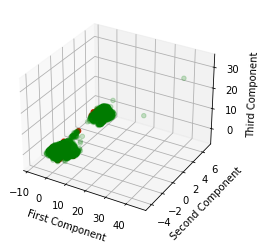

In [9]:
# Plot 3D result of PCA
plot_pca_3D(pca_components, y_train);

**Removing outliers (that are non anomalies)**  
Let's remove outliers in the non anomaly class and plot data again, in 3D and then in 2 dimensions.

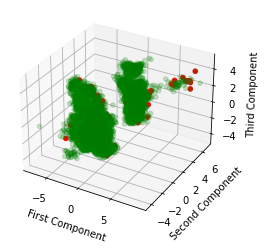

In [10]:
# Outliers in non anomaly data
indexes_outliers = np.argsort(pca_components[:, 1])[-2:][::-1]

# Removing outliers
X_train_removed = X_train.drop(indexes_outliers)
y_train_removed = y_train.drop(indexes_outliers)

# Fit PCA on cleaned data
pca_components_cleaned, _ = apply_PCA(X_train_removed, plot=False)

# Plot data without outliers
plot_pca_3D(pca_components_cleaned, y_train_removed)

**2D plot**

In [11]:
# Test values
pca_components_test, _ = apply_PCA(X_test, plot=False)
indexes_outliers_test = np.argsort(pca_components_test[:, 1])[-2:][::-1]
X_test_removed = X_test.drop(indexes_outliers_test)
X_test_values, _ = apply_PCA(X_test_removed, plot=False)

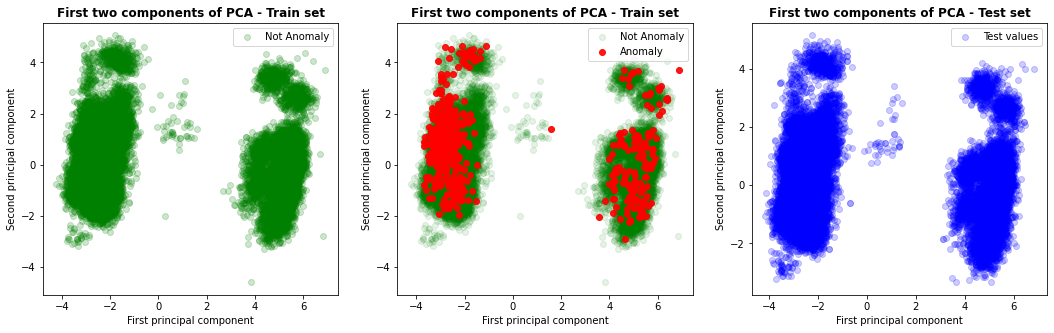

In [12]:
anomalies_cleaned = pca_components_cleaned[y_train_removed['Anomaly']==1]
not_anomalies_cleaned = pca_components_cleaned[y_train_removed['Anomaly']==0]

# Plot 2D Result of PCA
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].scatter(not_anomalies_cleaned[:, 0], not_anomalies_cleaned[:, 1], label='Not Anomaly', color='g', alpha=0.2)
ax[2].scatter(X_test_values[:, 0], X_test_values[:, 1], label='Test values', color='blue', alpha=0.2)
ax[1].scatter(not_anomalies_cleaned[:, 0], not_anomalies_cleaned[:, 1], label='Not Anomaly', color='g', alpha=0.1)
ax[1].scatter(anomalies_cleaned[:, 0], anomalies_cleaned[:, 1], label='Anomaly', color='r', alpha=0.9)
ax[0].set_title('First two components of PCA - Train set', fontweight='bold')
ax[1].set_title('First two components of PCA - Train set', fontweight='bold')
ax[2].set_title('First two components of PCA - Test set', fontweight='bold')
ax[0].set_xlabel('First principal component')
ax[0].set_ylabel('Second principal component')
ax[0].legend(loc='upper right')
ax[1].set_xlabel('First principal component')
ax[1].set_ylabel('Second principal component')
ax[2].set_xlabel('First principal component')
ax[2].set_ylabel('Second principal component')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right');

The problem seems to be that classes are highly **overlapping**, which will create strong noise in our predictions.   
Training and test sets seem to have similar data distribution, which is a good start.  
These plots are just for **visualization**, since two principal components explain only a little part of the total variance.

## 3. Feature Engineering <a class="anchor" id="FeatureEngineering"></a>

### 3.1 Sampling Methods (optional) <a class="anchor" id="SamplingMethods"></a>  
Dealing with highly unbalanced classes can be challenging. The **Synthetic Minority Oversampling Technique** can be used to oversample the minority class, by creating new datapoints from the original dataset. This is a type of data augmentation. However in the present case, there is a **strong overlapping classes** schema on our data, which results in ambiguous examples after SMOTE and thus, a lower public test score than without data augmentation. We can note that this technique leads to great **overfitting** !    

Below, an example of classifier using SMOTE in its classic form. Other SMOTE variants have been tested, without better results (SVM SMOTE, Borderline SMOTE).

**Classic SMOTE**

In [165]:
over = SMOTE(sampling_strategy=0.1) # Over sample minority class with SMOTE
under = RandomUnderSampler(sampling_strategy=0.3) # Under sampling majority class

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Apply SMOTE on dataset
X_train_smote, y_train_smote = pipeline.fit_resample(X_train_removed, y_train_removed)

print(f'New distribution of target :\n----------------------------\n{y_train_smote.value_counts()}')

# Build train set WITH SMOTE
X_train_smote, X_valid_nonused, y_train_smote, y_valid_nonused = train_test_split(X_train_smote, y_train_smote, test_size = 0.1, random_state = 0, stratify = y_train_smote.values)
# Build valid set WITHOUT SMOTE
X_train_nonused, X_valid, y_train_nonused, y_valid = train_test_split(X_train_removed, y_train_removed, test_size = 0.1, random_state = 0, stratify = y_train_removed.values)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_valid_scaled = scaler.transform(X_valid)

New distribution of target :
----------------------------
Anomaly
0          8963
1          2689
dtype: int64


As **XGBoost** is the model that allowed me to get the best score on public test set in the exploratory step, I stick with it when trying to improve the current performance with feature engineering.

Best AUC score (training) : 0.9265217543433015
Best params : {'eta': 0.01, 'eval_metric': 'auc', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'binary:logistic', 'scale_pos_weight': 9, 'subsample': 0.9}
CPU times: user 2min 40s, sys: 2.66 s, total: 2min 42s
Wall time: 44.9 s


<AxesSubplot:title={'center':'ROC Curve Validation set'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

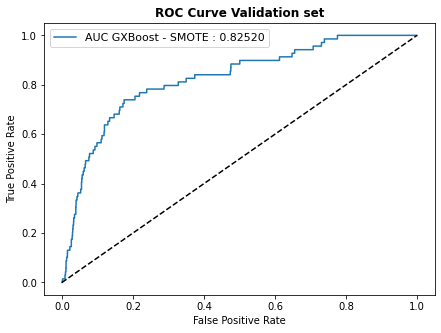

In [166]:
%%time

params ={'max_depth': [3],
         'eta':[1e-2],
        'learning_rate': [1e-2, 1e-1],
        'gamma':[1, 3],
        'subsample':[0.9],
        'objective':['binary:logistic'],
        'eval_metric':['auc'],
        'scale_pos_weight':[9]}

clf = XGBClassifier(booster='gbtree', n_estimators=50, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=3, random_state=0)
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False)

searchCV.fit(X_train_scaled, y_train_smote)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_valid_scaled)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve_manual(y_valid, preds_cv[:, 1], 'GXBoost - SMOTE', ax);

### 3.2 Enlarging feature space  <a class="anchor" id="EnlargeFeat"></a>    
Since the dataset is not massive, we can try to create features in order to ease the learning process. Here are the choices I made :  
* By looking at the dataset, I notice that several columns are dealing with only two values. A good start would be to **One Hot Encode** these features to prevent the model to learn hierarchy pattern between these values 
* I also notice that some features are dealing with **angles** or **torques**, and that these features are coming by pairs ; I decide to compute the **difference between the corresponding angles and torques**, in order to create new features that would reflect a disproportion in these values from a different view  
* Finally, because some features range are really small, I create a bunch of new features that are just the **squares** of original ones. The intuition behind this is to strengthen - if they exists - the weight of the anomalies  
* As mentionned in the data analysis part, some samples are **duplicated** in the datasets. We can hypothetize that these are not errors but rather that Veolia **specifically decided to measure again these items**. Following this reasonning, this could gives great information about the probability of these items to be anomalies. Indeed, when looking at the ratio of anomalies in the duplicated values, we find that the proportions are far much greather than the one observed in the entire dataset (around 50% vs less than 3% initially). Thus, I create a new feature `dup` that equals $1$ if the samples is duplicated, $0$ otherwise. This field allows the best model to gain 10 points in the public test score.

In [13]:
counts = y_train[X_train.duplicated(keep=False)].value_counts().values
print(f'Anomaly ratio in duplicated training samples : {100*(counts[1]/(counts[0] + counts[1])):.2f}%')

Anomaly ratio in duplicated training samples : 49.39%


In [14]:
# Features with only 2 values
list_indexes_short = [5, 6, 7, 9, 12, 23]

# One hot encoding
X_train_removed = pd.get_dummies(data=X_train_removed, columns=X_train_removed.columns[list_indexes_short])
X_test_removed = pd.get_dummies(data=X_test, columns=X_test.columns[list_indexes_short])

# List of features on which to apply engineering
list_to_square = ['START2_OP020_V_1angle', 'START2_OP020_V_2angle', 'START2_OP020_V_1torque', 'START2_OP020_V_2torque', \
                'START2_OP070_V_1angle', 'START2_OP070_V_2angle', 'START2_OP070_V_1torque', 'START2_OP070_V_2torque', \
                'START2_OP080_Vision_rondelleprog', 'START2_OP100_Capuchon_insertionmesure']
list_to_diff = ['START2_OP020_V_2angle', 'START2_OP020_V_2torque', 'START2_OP070_V_2angle', 'START2_OP070_V_2torque']
force_to_diff = ['START2_OP090_SnapRingPeakForce']

# Engineer features
X_train_removed_eng = X_train_removed.copy()
X_test_removed_eng = X_test_removed.copy()

for col in list_to_square:
    X_train_removed_eng[f'{col}_sq'] = X_train_removed_eng[col].apply(lambda x: x**2)
    X_test_removed_eng[f'{col}_sq'] = X_test_removed_eng[col].apply(lambda x: x**2)

for col in list_to_diff:
    col_to_sub = col.replace('_V_2', '_V_1')
    X_train_removed_eng[f'{col}_diff'] = X_train_removed_eng[col] - X_train_removed_eng[col_to_sub]
    X_test_removed_eng[f'{col}_diff'] = X_test_removed_eng[col] - X_test_removed_eng[col_to_sub]
    
for col in force_to_diff:
    col_to_sub = col.replace('Peak', 'MidPoint')
    X_train_removed_eng[f'{col}_diff'] = X_train_removed_eng[col] - X_train_removed_eng[col_to_sub]
    X_test_removed_eng[f'{col}_diff'] = X_test_removed_eng[col] - X_test_removed_eng[col_to_sub]
    
# Duplicate feature
idx_duplicates_train = X_train_removed_eng[X_train_removed_eng.duplicated(keep=False)].index.values
idx_duplicates_test = X_test_removed_eng[X_test_removed_eng.duplicated(keep=False)].index.values
X_train_removed_eng['dup'] = 0
X_train_removed_eng.loc[idx_duplicates_train, 'dup'] = 1
X_test_removed_eng['dup'] = 0
X_test_removed_eng.loc[idx_duplicates_test, 'dup'] = 1

In [15]:
print(f'Number of features post engineering : {X_train_removed_eng.shape[1]}')

Number of features post engineering : 49


### 3.3 Train test split  <a class="anchor" id="TrainTestSplit"></a>    
In the rest of the document, we will use the enlarged feature matrix, without SMOTE techniques.  
To **prevent further overfitting** when testing the public data, I decide to split the training dataset into :   
* A smaller training dataset : _(X_train_cut, y_train_cut)_  
* A validation set _(X_valid, y_valid)_, which will be used for hyperparameters tunning  

I make sure to use the `stratify` parameter to split the data, in order to keep the inital proportion of each classes in the splitted datasets.

In [16]:
X_train_cut, X_valid, y_train_cut, y_valid = train_test_split(X_train_removed_eng, 
                                                              y_train_removed, 
                                                              test_size = 0.1, 
                                                              random_state = 42,
                                                              stratify = y_train_removed.values)

### 3.4 Probability calibration  <a class="anchor" id="ProbCalib"></a>    

In our case, it could be interesting to get - not only the values of the predictions, ordered by their probability of being defectious - but also **well-calibrated predictions**, for which the predicted value of **0.8** (for example), would mean that the item has a probability of being defectious of **80%**. Indeed, this kind of technique helps human-interpretation of results.  
This can be done using the `CalibratedClassifierCV` function (invoked in our own _calibrate_predictions_ method), wihch fits a model on the predictions, with respect to the initial weights of the target, and return values smoothed in range $[0, 1]$.  

Diffenrent kinds of calibration exist. We implement two of them :  
* **Isotonic** calibration 
* **Sigmoid** calibration  

A good measure for calibration is the **Brier Score**, which I will display for each kind of calibration (the smaller the score, the better).  
As these calibrations can results in slightly different **AUC**, I also focus on trying them on the public test set, in order to check if they allow better predictions and thus higher rank in the challenge.  
To use probability calibration, it is important to get the **weights of target** in our original dataset. I create another split of the data, with respect to these weights, for the calibration step.

In [17]:
# Non anomaly ratio
num = (y_train_removed.value_counts()[0]/len(y_train_removed))
denom = (y_train_removed.value_counts()[1]/len(y_train_removed))
res = (num.values[0]/denom.values[0])

sample_weight = sample_weight = np.array([res if i == 1 else 1 for i in y_train_removed.values.ravel()])
res_array = sample_weight / len(sample_weight)

In [19]:
X_train_calib, X_valid_calib, y_train_calib, y_valid_calib, sw_train, sw_test = \
    train_test_split(X_train_removed_eng, y_train_removed, res_array, test_size=0.1, random_state=42, stratify = y_train_removed.values)

**Scaling Data**  
Because many features show range of values completely different, it is a wise step to **scale** the datasets. This will help the learning step, and will allow us to use **regularization techniques**.

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cut)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test_removed_eng)

In [21]:
scaler = StandardScaler()
X_train_calib_scaled = scaler.fit_transform(X_train_calib)
X_valid_calib_scaled = scaler.transform(X_valid_calib)

## 4. Models <a class="anchor" id="Models"></a>  

In this section, I try to fit different models to the splitted and scaled data. First, I train the algorithm on the training dataset, then I use **GridSearchCV** to fine-tune hyperparameters on the validation set, which leads to **greater performance** - especially on tree-based methods.  

Since applying **PCA** before training models did not improve my position in public leaderbord, I've kept all the features from enlarged feature matrix, but tried `regularization` parameters.  

Below the best algorithms are listed. I've tried other methods that did not show great performance or were too slow ; Logistic Regression, C-Support vector classification, etc.

### 4.1 Support Vector Machine (SVM)  <a class="anchor" id="SVM"></a>   

The **SGDClassifier** fits a Support Vector Machine model, using **stochastic gradient descent**, which allows a much faster learning process. However, the results obtained with this classifier show **poor performance**, on the validation set, as well as the public test set.

**Stochastic Gradient Descent**

In [177]:
%%time
params ={'loss':['modified_huber'],
         'penalty':['l2'],
         'alpha':[1e-1],
         'epsilon':[1e-5],
         'learning_rate':['invscaling'],
         'eta0':[1e-2],
         'early_stopping':[False],
         'class_weight':['balanced']}

clf = SGDClassifier(random_state=0, fit_intercept=False)

searchCV = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=params, 
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=False)

searchCV.fit(X_train_scaled, y_train_cut)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_valid_scaled)

Best AUC score (training) : 0.8691630670061313
Best params : {'penalty': 'l2', 'loss': 'modified_huber', 'learning_rate': 'invscaling', 'eta0': 0.01, 'epsilon': 1e-05, 'early_stopping': False, 'class_weight': 'balanced', 'alpha': 0.1}
CPU times: user 683 ms, sys: 98.2 ms, total: 781 ms
Wall time: 498 ms


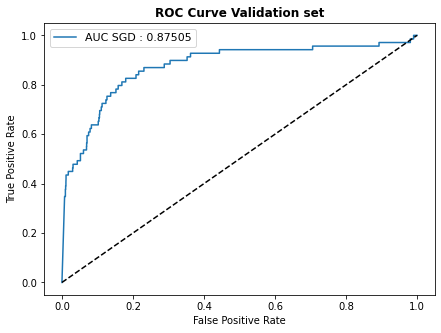

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve_manual(y_valid, preds_cv[:, 1], 'SGD', ax);

### 4.2 Xtreme Gradient Boosting (XGB)  <a class="anchor" id="XGB"></a>   

**XGBoost** is extensively used by Machine Learning practionnier, thank to its great amount of participation in winning solutions during Kaggle challenges. Let's try and implement a version that fits our problem, using the dedicated API : XGBClassifier.

**Hyperparameters**  
Larger ranges of hyperparameters have been tested iteratively. The one left below are the ones creating the best performance.  
* `max_depth` : The depth of the tree. Higher values lead to complex trees, and thus overfitting. 5 allows the model to learn quite quickly and perform well  
* `Learning rate`: Boosting learning rate. This rate must not be too big (too much bias) or too small (not enough learning)  
* `gamma`: Minimum loss reduction to make further partition on a leaf node  
* `subsample`: Subsample ratio of training instance  
* `eval_metric`: We want to maximize **AUC** for our problem  
* `scale_pos_weight` : Balancing of positive and negative weights. This parameter is essential regarding our dataset and its highly unbalanced classes. 9 seems the best value after multiple testing, even though it is not quite the ratio we observe in our _training data_

In [54]:
%%time

params ={'max_depth': [5],
        'learning_rate': [1e-1],
        'gamma':[0.3],
        'subsample':[0.9],
        'objective':['binary:logistic'],
        'eval_metric':['auc'],
        'scale_pos_weight':[9],
        'n_estimators':[60]}

clf = XGBClassifier(booster='gbtree')
cv = RepeatedStratifiedKFold(n_splits=3)
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False)

searchCV.fit(X_train_scaled, y_train_cut)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_valid_scaled) 

Best AUC score (training) : 0.8814854181963238
Best params : {'eval_metric': 'auc', 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60, 'objective': 'binary:logistic', 'scale_pos_weight': 9, 'subsample': 0.9}
CPU times: user 4min 31s, sys: 2.59 s, total: 4min 34s
Wall time: 1min 13s


In [55]:
# Save model
pickle.dump(searchCV.best_estimator_, open('models/XGBoost.pkl.dat', 'wb'))

In [56]:
# Load model
loaded_model = pickle.load(open('models/XGBoost.pkl.dat', 'rb'))

**Probability Calibration**  
As mentionned earlier, we fit a calibration on our predictions, in order to smoothen them in the range $[0, 1]$.  
For the XGBoostClassifier, the calibrated predictions don't seem to outperform the original results on the **public test score**, thus, we stick with the orginal model (still, it is interesting to notice that Isotonic calibration outperforms original predictions on Validation set).

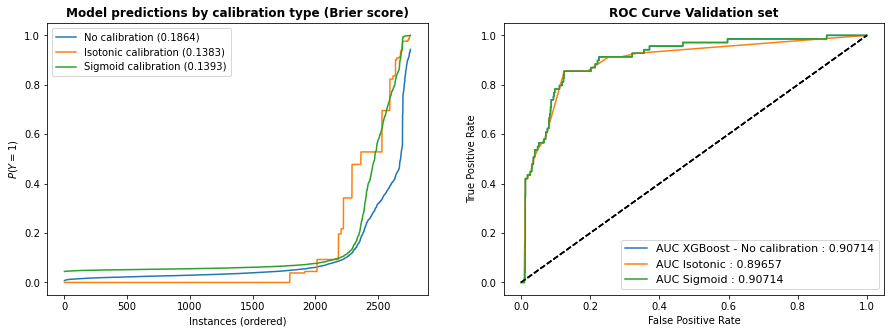

In [57]:
# Load model
loaded_model = pickle.load(open('models/XGBoost.pkl.dat', 'rb'))

# No calibration
preds_clf = loaded_model.predict_proba(X_valid_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_valid_calib, preds_clf, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
plot_roc_curve_manual(y_valid_calib, preds_clf, 'XGBoost - No calibration', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_sig, 'Sigmoid', ax[1]);

XGBClassifier gives predictions in the range $[0, 1]$, but it is still interesting to try calibration techniques. In this case, it does not improve the results for the AUC metric.

### 4.3 LightGBM <a class="anchor" id="LGB"></a>

**LightGBM** is a gradient boosting framework that uses tree-based learning algorithm.  
By creating asymetric trees when selecting only promising leaves, LightGBM can achieve **faster training** step than XGBoost.  
The focus on speed of training is quite useful, especially when trying large set of parameters for **GridSearch**.  

Similar to XGBoost, I've tried different set of parameters and the one below were leading to best performance.

In [27]:
%%time

params ={'learning_rate':[5e-2],
        'max_depth': [4],
        'reg_alpha':[1e-1],
        'reg_lambda':[1e-3],
        'gamma':[0.3],
        'subsample':[0.9],
        'objective':['binary'],
        'eval_metric':['auc'],
        'scale_pos_weight':[1]}


clf = LGBMClassifier(n_estimators=50, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=3, random_state=0)
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False)

searchCV.fit(X_train_scaled, y_train_cut)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_valid_scaled) 

Best AUC score (training) : 0.8870172044702539
Best params : {'eval_metric': 'auc', 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'scale_pos_weight': 1, 'subsample': 0.9}
CPU times: user 33 s, sys: 1.83 s, total: 34.8 s
Wall time: 10.6 s


In [28]:
# Save model
pickle.dump(searchCV.best_estimator_, open('models/LightGBM_GridSearch.pkl.dat', 'wb'))

In [29]:
# Load model
loaded_model = pickle.load(open('models/LightGBM_GridSearch.pkl.dat', 'rb'))

**Calibration predictions**

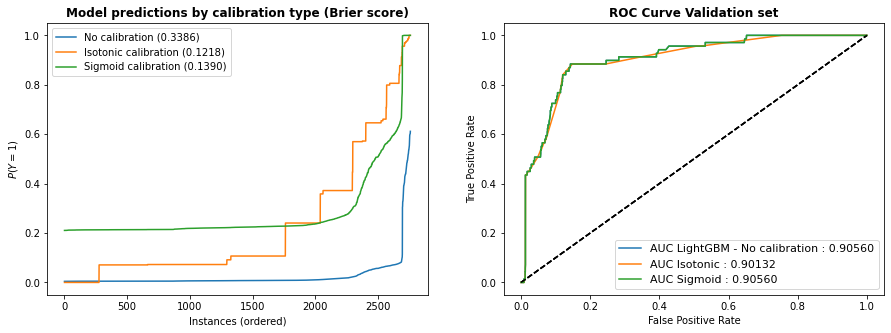

In [26]:
# Load model
loaded_model = pickle.load(open('models/LightGBM_GridSearch.pkl.dat', 'rb'))

# No calibration
preds_clf = loaded_model.predict_proba(X_valid_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_valid_calib, preds_clf, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
plot_roc_curve_manual(y_valid_calib, preds_clf, 'LightGBM - No calibration', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_sig, 'Sigmoid', ax[1]);

For this particular problem, LightGBM AUC score is greater than the one obtained with XGBoost on the validation set. However, it led to slightly bigger **overfitting**, and the performance on public test set for LightGBM did not outperformed the on with XGBoost.  
Predictions made by **LightGBM** are not well-calibrated (see above). Sigmoid calibration achieve the same performance, but smoothen the predictions in the range $[0, 1]$ (i.e lower **Brier Score**).

### 4.4 CatBoost <a class="anchor" id="CatBoost"></a>

CatBoost is again a library for **Gradient Boosting** on decision tree, developped by Yandex.  
It is supposed to provide better generalization by reducing tree correlation and also allow to use categorical feature without pre-processing.  
The method remains the same as previously, I use `GridSearchCV` and cross-validation to find best hyper-parameters.

In [31]:
%%time

params ={'learning_rate':[5e-2],
        'max_depth': [4],
        'reg_lambda':[1],
        'bootstrap_type': ['Bernoulli'],
        'subsample':[0.95],
        'eval_metric':['AUC'],
        'scale_pos_weight':[15],
        'logging_level':['Silent']}

clf = CatBoostClassifier(n_estimators=60, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=3, random_state=0)
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False)

searchCV.fit(X_train_scaled, y_train_cut)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_valid_scaled)

Best AUC score (training) : 0.8834076905595126
Best params : {'bootstrap_type': 'Bernoulli', 'eval_metric': 'AUC', 'learning_rate': 0.05, 'logging_level': 'Silent', 'max_depth': 4, 'reg_lambda': 1, 'scale_pos_weight': 15, 'subsample': 0.95}
CPU times: user 1min 30s, sys: 9.59 s, total: 1min 40s
Wall time: 36.6 s


In [32]:
# Save model
pickle.dump(searchCV.best_estimator_, open('models/catboost_GridSearch.pkl.dat', 'wb'))

**Calibration predictions**

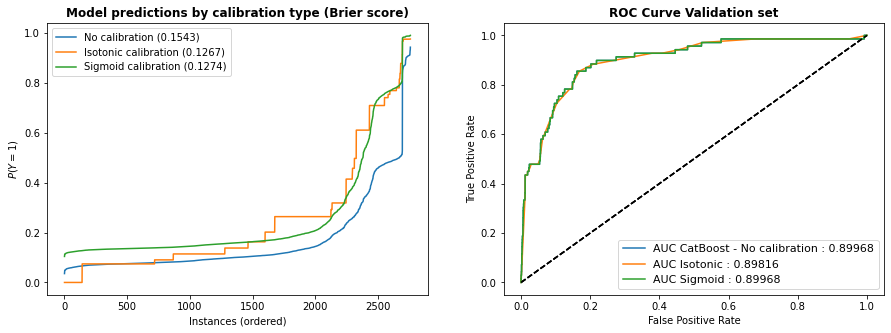

In [33]:
# Load model
loaded_model = pickle.load(open('models/catboost_GridSearch.pkl.dat', 'rb'))

# No calibration
preds_clf = loaded_model.predict_proba(X_valid_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_valid_calib, preds_clf, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
plot_roc_curve_manual(y_valid_calib, preds_clf, 'CatBoost - No calibration', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_sig, 'Sigmoid', ax[1]);

Performance is similar to the one observed with LightGBM algorithm on the validation set. However, this technique led again to bigger **overfitting** and the public test score was lower than the one with XGBoost.

### 4.5 Random forest <a class="anchor" id="RandF"></a>

A **Random Forest** is a meta-estimator that fits decision tree classifiers. It does not use gradient boosting techniques, which is slower than the techniques we used before, but is still frequently used in competitions since it uses averaging to improve performance and control overfitting.  

To allow the algorithm to automatically adjust **class weights**, I set the `class_weight` to _'balanced'_. 

In [35]:
%%time
params ={'max_depth': [5],
        'criterion': ['gini'],
        'max_features': ['auto'],
        'class_weight':['balanced'],
        'bootstrap': [True]}

clf = RandomForestClassifier(n_estimators=60)
cv = RepeatedStratifiedKFold(n_splits=3, random_state=0)
searchCV = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    scoring='roc_auc',
    cv=cv,
    verbose=False)

searchCV.fit(X_train_scaled, y_train_cut)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_valid_scaled)

Best AUC score (training) : 0.8650642316909983
Best params : {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
CPU times: user 39.3 s, sys: 398 ms, total: 39.7 s
Wall time: 40 s


In [36]:
# Save model
pickle.dump(searchCV.best_estimator_, open('models/randomF_GridSearch.pkl.dat', 'wb'))

In [37]:
# Load model
loaded_model = pickle.load(open('models/randomF_GridSearch.pkl.dat', 'rb'))

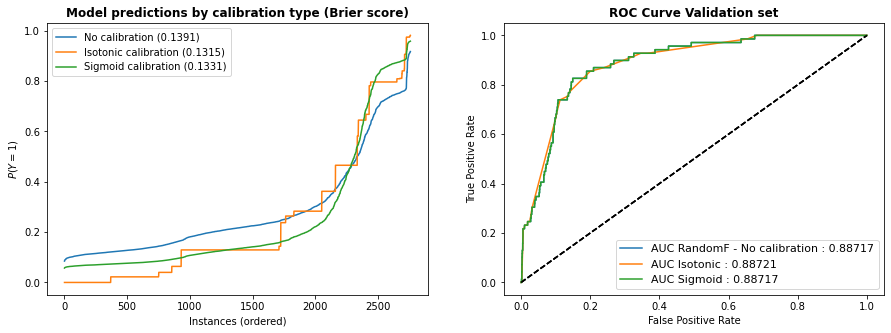

In [38]:
# Load model
loaded_model = pickle.load(open('models/randomF_GridSearch.pkl.dat', 'rb'))

# No calibration
preds_clf = loaded_model.predict_proba(X_valid_calib_scaled)[:, 1]
clf_brier_score = brier_score_loss(y_valid_calib, preds_clf, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(loaded_model, 
                                                   X_train_calib_scaled, y_train_calib, 
                                                   X_valid_calib_scaled, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
plot_roc_curve_manual(y_valid_calib, preds_clf, 'RandomF - No calibration', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_iso, 'Isotonic', ax[1])
plot_roc_curve_manual(y_valid_calib, preds_calib_sig, 'Sigmoid', ax[1]);

Without Gradient boosting, the performance is quite lower on validation set. 

## 5. Stacking <a class="anchor" id="Stacking"></a>

**Stacking outputs** from individual classifiers, and use another classifier to compute final prediction is commonly used  to improve performance and also to reduce **overfitting**.    

In this section I use the `StackingClassifier` method from Scikit-learn, to build a meta-estimator based on classifiers listed previously (i.e classifiers that showed greatest performance on public test score).  

For each classifier, I use the best parameters found with `GridSearchCV` method during my different tries, then I build a final classifier using **XGBoost**, since it is the one that showed best individual performance.  

Finally, I plot the contributions from each classifier, and the final AUC on validation set for each individual classifiers, as for the meta-classifier.  

The **AUC** on validation set is indeed greater with **stacking method**, however, when dealing with public test dataset, the performance of this meta-classifier did not improve the leaderboard position I obtained with XGBoost only.

_Source : https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/_

In [44]:
%%time

def get_stacking():
    ''' Define stacking strategy '''
    
    # Base models
    level0 = list()
    level0.append(('XGB', XGBClassifier(eta= 0.01, gamma=0.3, eval_metric='auc', learning_rate=0.1, max_depth=5, objective='binary:logistic', \
                                       scale_pos_weight=9, subsample=0.9, n_estimators=50)))
    level0.append(('LGBM', LGBMClassifier(eval_metric='auc', gamma=0.3, learning_rate=5e-2, max_depth=5, objective='binary', \
                                             reg_alpha=1e-1, reg_lambda=1e-3, scale_pos_weight=1)))
    level0.append(('RandomF', RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=5, max_features='auto')))

    # Learner model
    level1 = XGBClassifier(learning_rate=0.1)
    
    # Stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
    
    return model

def get_models():
    ''' Get list of models to evaluate '''
    
    models = dict()
    models['XGB'] = XGBClassifier(eta=0.01, gamma=0.3, eval_metric='auc', learning_rate=0.1, max_depth=5, objective='binary:logistic', \
                                       scale_pos_weight=9, subsample=0.9, n_estimators=50)
    models['LGBM'] = LGBMClassifier(eval_metric='auc', gamma=0.3, learning_rate=5e-2, max_depth=5, objective='binary', \
                                             reg_alpha=1e-1, reg_lambda=1e-3, scale_pos_weight=1)
    models['RandomF'] = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=5, max_features='auto')
    models['stacking'] = get_stacking()
    
    return models

def evaluate_model(model, X, y):
    ''' Evalue model (using cross-val)'''
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    
    return scores

X, y = X_train_scaled, y_train_cut
models = get_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('AUC Scores \n----------------------------')
    print(f'{name} : {np.mean(scores):.5f}  ({np.std(scores):.5f})')

AUC Scores 
----------------------------
XGB : 0.88393  (0.01188)
AUC Scores 
----------------------------
LGBM : 0.88231  (0.00947)
AUC Scores 
----------------------------
RandomF : 0.88535  (0.00768)
AUC Scores 
----------------------------
stacking : 0.88131  (0.00824)
CPU times: user 7min 23s, sys: 6.17 s, total: 7min 29s
Wall time: 2min 56s


**Plots**

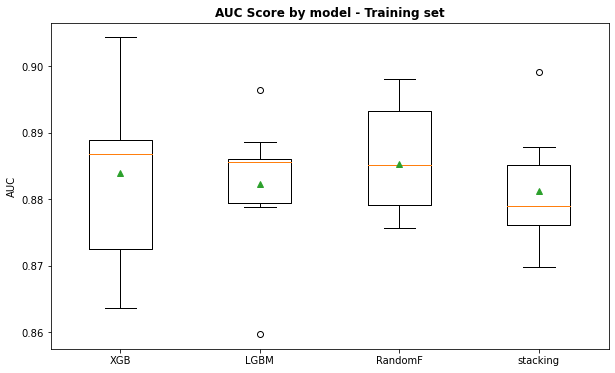

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('AUC Score by model - Training set', fontweight='bold')
plt.ylabel('AUC')
plt.show()

CPU times: user 1min 8s, sys: 1.04 s, total: 1min 9s
Wall time: 27.7 s


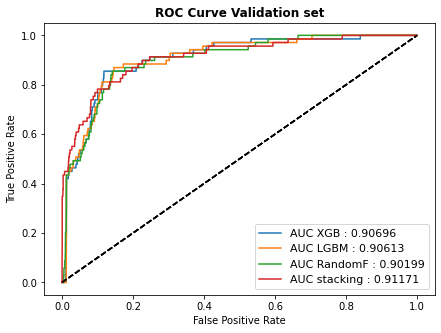

In [46]:
%%time 

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for name, model in models.items():
    clf = model
    clf.fit(X_train_scaled, y_train_cut)
    y_hat = clf.predict_proba(X_valid_scaled)[:, 1]
    plot_roc_curve_manual(y_valid.values.ravel(), y_hat, f'{name}', ax);

In [47]:
y_hat_test = models['stacking'].predict_proba(X_test_scaled)[:, 1]
np.savetxt('Stacked_model.csv', y_hat_test, fmt = '%1.6f', delimiter=',')

## Submissions

In [58]:
loaded_model = pickle.load(open('models/XGBoost.pkl.dat', 'rb'))
preds_test_now = loaded_model.predict_proba(X_test_scaled)[:, 1]
np.savetxt('XGBoost.csv', preds_test_now, fmt = '%1.6f', delimiter=',')